# Stock Prediction with Recurrent Neural Network

In this notebook, we will demontrate how to use LSTM to predict Nasdaq index. 

In [84]:
import time, os
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Preprocess Data
Before training a machine learning model, one the most crucial step is to data preparation. The stock prices of the Nasdaq 100 are with quite different scales. If we treat them equally, the model might put more weights to the stocks with larger scale. We will apply the standard normalization by the formula X - u/ sigma, where is u the mean and is the standard deviation of each stock and the index. To demonstrate the normalization process, we plot the Nasdaq index value before and after the normalization process as below. Each stork is also being normalized by the same fashion.

In [9]:
NASDAQ = '~/LSTM-Stock-Pred/nasdaq/data/nasdaq/small/nasdaq100_padding.csv'
raw_data = pd.read_csv(NASDAQ)

In [32]:
def preprocess_data(raw_data, col_names):
    scale = StandardScaler().fit(raw_data)
    proc_dat = scale.transform(raw_data)
    mask = np.ones(proc_dat.shape[1], dtype=bool)
    dat_cols = list(raw_data.columns)
    for col_name in col_names:
        mask[dat_cols.index(col_name)] = False
    X = proc_dat[:, mask]
    y = proc_dat[:, ~mask]
    return X, y, scale
    
X, y, scale = preprocess_data(raw_data, ['NDX'])

### Visualize Normalized Nasdaq Index

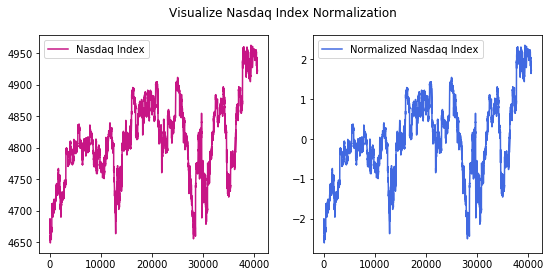

In [34]:
def visualize_normalize_index(raw_data, scaled_data):
    fig=plt.figure(figsize=(9,4))
    fig.suptitle('Visualize Nasdaq Index Normalization')
    plt.plot(raw_data['NDX'])
    plt.subplot(1,2,1)
    plt.plot(raw_data['NDX'], '-', color='mediumvioletred', label='Nasdaq Index')
    plt.legend(loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(scaled_data, color='royalblue', label='Normalized Nasdaq Index')
    plt.legend(loc='upper left')
    fig.savefig("Nasdaq_100_normalization.png")
    
visualize_normalize_index(raw_data, y)

### Train and test data split

To avoid the model overfitting, we will also need split the all the data into two parts. The first 70% of the data will be used as the training data and the model will be able to see this part of data during the training, and the remaining 30% will be reserved to be test data and will only use it to evaludate the model accuracy after the traning is complete. 

## Create Model
Next, we need to create a model and will train it with the training data. 
The model consists of two LSTM layers, and there is one dropout layer after each LSTM layer whcih will randomly disable some neurons during the traning to avoid model overfitting. We stack multiple LSTM layers together to allow the model to learn complicate temporal dynamics between the index and all of its stocks. The output of the second dropout layer will connect to a dense layer (fully connected layer) before send to the activation function, which will map the dense layer output to a prediction value. We are using the mean squared error function as our loss function to force the model to make prediction as close to the training data as possible.


The model will looks like below:
    
        LSTM1 --> Dropout1 --> LSTM2 --> Dropout2 --> Dense --> Activation

In [66]:
def build_model(window, input_size, output_size = 1):
    model = Sequential()

    # LSTM1 layer
    model.add(LSTM(
        units = 64, 
        input_shape = (window, input_size),
        return_sequences=True)) # return_sequences to allow us to stack another LSTM layer
    # Dropout1 layer
    model.add(Dropout(0.4))
    
    # LSTM2 layer
    model.add(LSTM(
        64,
        return_sequences=False))
    # Dropout2 layer          
    model.add(Dropout(0.3))
    
    # Dense layer
    model.add(Dense(units=1))
    model.add(Activation("linear"))
    
    # Mean squared error loss function
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    return model

## Training the Model

## Rolling window Training

Although the LSTM in theory could memorize the long term feature, in reality current data will only depend on data happened in the limited time window. For example, it is unlikely the stock price from 1 years is helpful for us to predict the stock price at 3:00am of next monday. In addition, the forget gate in the LSTM has the same vanishing/exploding gradient issue with RNN. If we do not limit the window size, the model might take very long to train and the converent might be very slow. 


In [102]:
train_test_split = 0.7
batch_size = 128
rolling_window_size = 20
train_size = int(X.shape[0] * train_test_split)
n_epochs = 32 

In [115]:
# Build the model
model = build_model(window = rolling_window_size - 1, input_size = X.shape[1], output_size = 1)

In [116]:
# Train the model
loss_epoches = []
for i in tqdm(range(n_epochs)):
    perm_idx = np.random.permutation(train_size - rolling_window_size)
    
    sum_loss = 0
    for j in range(0, train_size, batch_size):    
        batch_idx = perm_idx[j:(j + batch_size)]

        X_batch = np.zeros((len(batch_idx), rolling_window_size - 1, X.shape[1]))
        y_history = np.zeros((len(batch_idx), rolling_window_size - 1, 1))
        y_target = y[batch_idx + time_window]

        for k in range(len(batch_idx)):
            X_batch[k, :, :] = X[batch_idx[k] : (batch_idx[k] + rolling_window_size - 1), :]
            y_history[k, :] = y[batch_idx[k] : (batch_idx[k] + rolling_window_size - 1)]
        loss =  model.train_on_batch(X_batch, y_target)[0]
        sum_loss += loss / batch_size
    loss_epoches.append(sum_loss)
    


100%|██████████| 32/32 [03:57<00:00,  7.67s/it]

## Visualize the training loss

The model is being trained with 32 epochs and we can see that the MSE error after each epochs is descenting, which indicats that the model is convergenting and its prediction accuracy is improving over each epoch. Also we notice that after 32 epochs, the error is plateaued and more training not only will not improve the model performance anymore but also might cause the model overfitting the training data. That's why we only train for 32 epochs. 

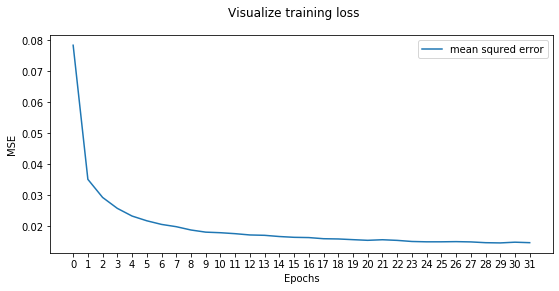

In [117]:
fig=plt.figure(figsize=(9,4))
fig.suptitle('Visualize training loss')
plt.plot(loss_epoches, label='mean squred error')
plt.xticks(range(0, n_epochs))
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('MSE')
fig.savefig("training_loss.png")

## Prediction


After the model has been trained, we will freeze all the parameters in the model and use it to make prediction. The following figure is the results when we apply the model to the entire dataset. It is expected that prediction results are good in the training data section as the model has seen those data during the training. In the testing data section, the model can predict the trend correctly but failed to predict the correct scale. This is not a very suprising to us as the stock market is notoriously hard to predict. Even though we could not predict the exact value of the index, if we could know the trend ahead of time of ahead of others, this could be very helpful to us. 

In [118]:
# Use the trained model to make prediction
total_size = X.shape[0]
perm_idx = range(0, total_size - rolling_window_size)

j = 0

y_pred = []
n_iters = 0
while j < total_size:    
    batch_idx = perm_idx[j:(j + batch_size)]
    X_batch = np.zeros((len(batch_idx), rolling_window_size - 1, X.shape[1]))
    y_history = np.zeros((len(batch_idx), rolling_window_size - 1, 1))

    for k in range(len(batch_idx)):
        X_batch[k, :, :] = X[batch_idx[k] : (batch_idx[k] + rolling_window_size - 1), :]

    j += batch_size
    y_pred_batch = model.predict_on_batch(X_batch)
    for yy in y_pred_batch:
        y_pred.append(yy)
    n_iters += 1

In [119]:
y_pred = np.array(y_pred).reshape(-1,1)

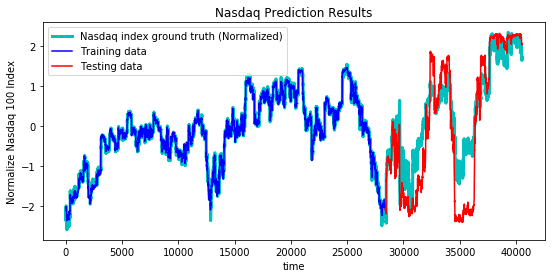

In [120]:
# Visualize the results
fig=plt.figure(figsize=(9,4))

plt.plot(range(0, total_size), y, '-c', lw=3, label = 'Nasdaq index ground truth (Normalized)')
plt.plot(range(0, train_size), y_pred[0:train_size], '-b', label = 'Training data')
plt.plot(range(train_size, len(y_pred)), y_pred[train_size:], '-r', label = 'Testing data')
plt.legend(loc='best')

plt.title('Nasdaq Prediction Results')
plt.xlabel('time')
plt.ylabel('Normalize Nasdaq 100 Index')
plt.show()
fig.savefig("final_prediction.png")